# Cifar-10 이미지 분류(Data Aumentation)

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np

In [3]:

# 실행할 때마다 같은 결과를 출력하기 위한 seed 값 설정
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
# 나중에 지정될 변수의 값을 미리 세팅
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 100
DATA_AUGMENTATION = True
NUM_PREDICTIONS = 20
SAVE_DIR = os.path.join(os.getcwd(), 'model')
MODEL_NAME = 'keras_cifar10_trained_model.h5'

In [5]:
# The data, split between train and test sets:
(x_train, y_train0), (x_test, y_test0) = cifar10.load_data()
print('x_train shape', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 18s 0us/step
x_train shape (50000, 32, 32, 3)
50000 train samples
10000 test samples


### 데이터 확인

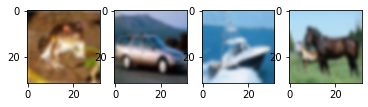

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(141)
plt.imshow(x_train[0], interpolation="bicubic")
plt.grid(False)
plt.subplot(142)
plt.imshow(x_train[4], interpolation="bicubic")
plt.grid(False)
plt.subplot(143)
plt.imshow(x_train[8], interpolation="bicubic")
plt.grid(False)
plt.subplot(144)
plt.imshow(x_train[12], interpolation="bicubic")
plt.grid(False)
plt.show()

In [7]:
y_train0[0]

array([6], dtype=uint8)

In [8]:
# 자료형을 실수로 변환한 후 정규화
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [9]:
# One-hot enchoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train0, NUM_CLASSES)
y_test = to_categorical(y_test0, NUM_CLASSES)
y_train.shape, y_test.shape


((50000, 10), (10000, 10))

### 모델 정의 / 설정 / 학습

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), #필터=마스크=커널 갯수32
                 padding='same',
                 input_shape=x_train.shape[1:], #(50000, 32, 32, 3)에서 shape[1:]은 뒤에 3개만 ㅋ.ㅋ
                 activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [11]:
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(learning_rate = 0.0001, decay=1e-6)

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelpath = "model/cifar10-aug-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss',
                               verbose=1,save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [15]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0
)
datagen.fit(x_train)

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, stratify=y_train, test_size=0.2, random_state=seed
)

In [19]:
history = model.fit(datagen.flow(x_train, y_train,
                                batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stopping_callback,checkpointer])

Epoch 1/100
1250/1250 [==============================] - 21s 17ms/step - loss: 1.6200 - accuracy: 0.4084 - val_loss: 1.5108 - val_accuracy: 0.4520

Epoch 00001: val_loss improved from inf to 1.51082, saving model to model/cifar10-aug-01-1.5108.hdf5
Epoch 2/100
1250/1250 [==============================] - 21s 17ms/step - loss: 1.5107 - accuracy: 0.4507 - val_loss: 1.3939 - val_accuracy: 0.4991

Epoch 00002: val_loss improved from 1.51082 to 1.39389, saving model to model/cifar10-aug-02-1.3939.hdf5
Epoch 3/100
1250/1250 [==============================] - 21s 17ms/step - loss: 1.4408 - accuracy: 0.4778 - val_loss: 1.3372 - val_accuracy: 0.5276

Epoch 00003: val_loss improved from 1.39389 to 1.33720, saving model to model/cifar10-aug-03-1.3372.hdf5
Epoch 4/100
1250/1250 [==============================] - 21s 17ms/step - loss: 1.3765 - accuracy: 0.5052 - val_loss: 1.2442 - val_accuracy: 0.5489

Epoch 00004: val_loss improved from 1.33720 to 1.24423, saving model to model/cifar10-aug-04-1.24

In [20]:
from tensorflow.keras.models import load_model
best_model = load_model('./model/cifar10-aug-58-0.6541.hdf5')

In [21]:
acc = best_model.evaluate(x_test, y_test, verbose=2)[1]
print(f"\n Test Accuracy: {acc:.4f}")

313/313 - 1s - loss: 0.6770 - accuracy: 0.7717

 Test Accuracy: 0.7717


In [26]:
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
y_loss = history.history['loss']
y_acc = history.history['accuracy']

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

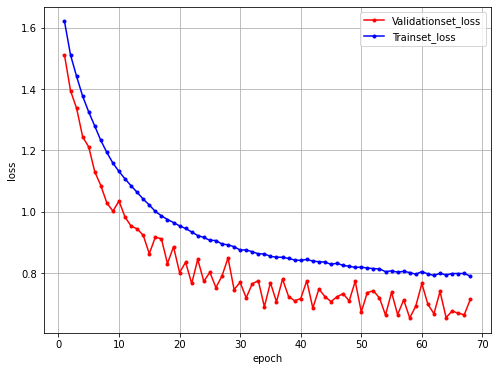

In [27]:
x_len = np.arange(1, len(y_loss)+1)
plt.figure(figsize=(8,6))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Validationset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

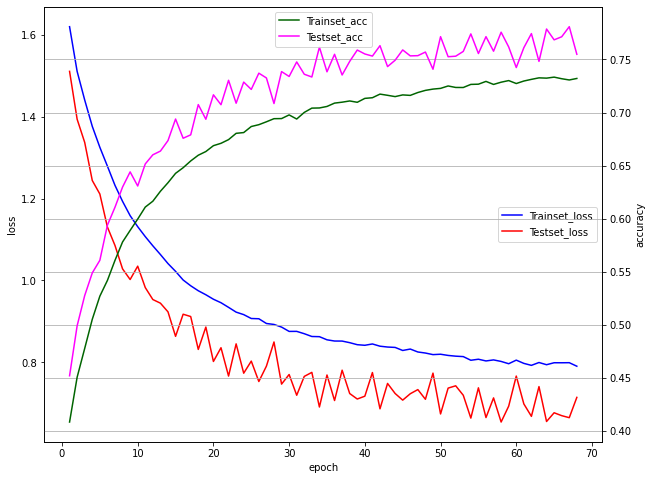

In [29]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c='blue', label='Trainset_loss')
ax0.plot(x_len, y_vloss, c='red', label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='center right')
ax1.legend(loc='upper center')
plt.grid()
plt.show()